<a href="https://colab.research.google.com/github/zpsy-hub/Data-Mining-Principles/blob/main/Data_Mining_Principles_Clustering_w_Avg_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

Load and Explore Data

In [ ]:
# Load datasets
df_transaction = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Transaction_Data_cleaned.csv')
df_customer_feedback = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Customer_Feedback_Data_cleaned.csv')
df_product_offering = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Data Mining Principles/cleaned data/Product_Offering_Data_cleaned.csv')

# Check data shapes
print("Transaction data shape:", df_transaction.shape)
print("Feedback data shape:", df_customer_feedback.shape)
print("Product data shape:", df_product_offering.shape)

Transaction data shape: (5000, 9)
Feedback data shape: (4959, 4)
Product data shape: (10, 7)


Feature Engineering

In [ ]:
# Get unique customers
unique_customers = df_transaction['Customer_ID'].unique()
customer_features = pd.DataFrame({'Customer_ID': unique_customers})

# Transaction amount metrics
transaction_amount = df_transaction.groupby('Customer_ID')['Transaction_Amount'].agg(
    ['sum', 'count', 'mean', 'min', 'max']).reset_index()
transaction_amount.columns = ['Customer_ID', 'Total_Transaction_Amount',
                             'Transaction_Count', 'Avg_Transaction_Amount',
                             'Min_Transaction_Amount', 'Max_Transaction_Amount']

# Transaction types
transaction_types = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Type'],
    normalize='index'
).reset_index()

# Transaction amount categories
transaction_categories = pd.crosstab(
    df_transaction['Customer_ID'],
    df_transaction['Transaction_Amount_Category'],
    normalize='index'
).reset_index()

# Feedback metrics
feedback_metrics = df_customer_feedback.groupby('Customer_ID').agg(
    Feedback_Count=('Satisfaction_Score', 'count'),
    Avg_Satisfaction=('Satisfaction_Score', 'mean'),
    Avg_Recommendation=('Likelihood_to_Recommend', 'mean')
).reset_index()

# Merge all features
customer_features = customer_features.merge(transaction_amount, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_types, on='Customer_ID', how='left')
customer_features = customer_features.merge(transaction_categories, on='Customer_ID', how='left')
customer_features = customer_features.merge(feedback_metrics, on='Customer_ID', how='left')

# Add recency feature
last_transaction_date = df_transaction.groupby('Customer_ID')['Transaction_Date'].max().reset_index()
last_transaction_date.columns = ['Customer_ID', 'Last_Transaction_Date']
max_date = pd.Timestamp('2023-07-31')

# Ensure Last_Transaction_Date is datetime type
last_transaction_date['Last_Transaction_Date'] = pd.to_datetime(last_transaction_date['Last_Transaction_Date'])
last_transaction_date['Days_Since_Last_Transaction'] = (
    max_date - last_transaction_date['Last_Transaction_Date']
).dt.days
customer_features = customer_features.merge(
    last_transaction_date[['Customer_ID', 'Days_Since_Last_Transaction']],
    on='Customer_ID', how='left'
)

# Is repeat customer?
customer_features['Is_Repeat_Customer'] = customer_features['Transaction_Count'] > 1

# Fill NaNs
customer_features = customer_features.fillna(0)

# Create engagement score
customer_features['Engagement_Score'] = (
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.7 +
    (customer_features['Feedback_Count'] / customer_features['Feedback_Count'].max()) * 0.3
) * 10

# Create customer value score
customer_features['Customer_Value'] = (
    (customer_features['Total_Transaction_Amount'] / customer_features['Total_Transaction_Amount'].max()) * 0.8 +
    (customer_features['Transaction_Count'] / customer_features['Transaction_Count'].max()) * 0.2
) * 10

# Print with new features
customer_features.head(5)

,Customer_ID,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Bill Payment,Investment,Loan Payment,Purchase,...,Low,Medium,Very High,Feedback_Count,Avg_Satisfaction,Avg_Recommendation,Days_Since_Last_Transaction,Is_Repeat_Customer,Engagement_Score,Customer_Value
0,393,22365.000000,7,3195.000000,1535.0,4968.000000,0.428571,0.428571,0.000000,0.142857,...,0.000000,0.285714,0.285714,1,1.000000,3.0,7,True,4.000000,1.442427
1,826,8182.422663,3,2727.474221,323.0,4123.000000,0.333333,0.000000,0.333333,0.333333,...,0.333333,0.000000,0.666667,6,6.166667,5.5,15,True,3.000000,0.595261
2,916,18406.000000,9,2045.111111,10.0,4616.000000,0.333333,0.111111,0.333333,0.222222,...,0.444444,0.222222,0.222222,7,2.714286,5.0,34,True,6.461538,1.685419
3,109,7492.000000,5,1498.400000,72.0,4549.000000,0.200000,0.400000,0.200000,0.200000,...,0.600000,0.000000,0.200000,3,3.000000,7.0,77,True,3.384615,0.891670
4,889,6348.834015,3,2116.278005,1531.0,3024.834015,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.666667,0.000000,5,5.000000,5.6,108,True,2.769231,0.565295


RFM Features

In [ ]:
# Calculate RFM (Recency, Frequency, Monetary) metrics
rfm = customer_features[['Customer_ID', 'Days_Since_Last_Transaction',
                        'Transaction_Count', 'Total_Transaction_Amount']].copy()
rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

# Convert recency to a score where lower is better
rfm['Recency'] = rfm['Recency'].max() - rfm['Recency']

# Create quartiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to integers
rfm['R_Quartile'] = rfm['R_Quartile'].astype(int)
rfm['F_Quartile'] = rfm['F_Quartile'].astype(int)
rfm['M_Quartile'] = rfm['M_Quartile'].astype(int)

# RFM Score
rfm['RFM_Score'] = rfm['R_Quartile'] + rfm['F_Quartile'] + rfm['M_Quartile']

# Merge RFM metrics back to customer features
customer_features = customer_features.merge(
    rfm[['Customer_ID', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'RFM_Score']],
    on='Customer_ID', how='left'
)

# Print with new features
customer_features.head(5)

,Customer_ID,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Bill Payment,Investment,Loan Payment,Purchase,...,Avg_Satisfaction,Avg_Recommendation,Days_Since_Last_Transaction,Is_Repeat_Customer,Engagement_Score,Customer_Value,R_Quartile,F_Quartile,M_Quartile,RFM_Score
0,393,22365.000000,7,3195.000000,1535.0,4968.000000,0.428571,0.428571,0.000000,0.142857,...,1.000000,3.0,7,True,4.000000,1.442427,4,4,4,12
1,826,8182.422663,3,2727.474221,323.0,4123.000000,0.333333,0.000000,0.333333,0.333333,...,6.166667,5.5,15,True,3.000000,0.595261,3,1,2,6
2,916,18406.000000,9,2045.111111,10.0,4616.000000,0.333333,0.111111,0.333333,0.222222,...,2.714286,5.0,34,True,6.461538,1.685419,2,4,4,10
3,109,7492.000000,5,1498.400000,72.0,4549.000000,0.200000,0.400000,0.200000,0.200000,...,3.000000,7.0,77,True,3.384615,0.891670,1,2,1,4
4,889,6348.834015,3,2116.278005,1531.0,3024.834015,0.000000,1.000000,0.000000,0.000000,...,5.000000,5.6,108,True,2.769231,0.565295,1,1,1,3


Prepare Data for Clustering

In [ ]:
# Select features for clustering
clustering_features = [
    'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
    'Bill Payment', 'Investment', 'Loan Payment', 'Purchase',  # Transaction type percentages
    'Low', 'Medium', 'High', 'Very High',  # Transaction amount categories
    'Avg_Satisfaction', 'Avg_Recommendation',
    'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value',
    'R_Quartile', 'F_Quartile', 'M_Quartile'
]

# Make sure all features exist in the dataframe
clustering_features = [f for f in clustering_features if f in customer_features.columns]
print(f"Using {len(clustering_features)} features for clustering: {clustering_features}")

# Create a subset for clustering
cluster_data = customer_features[clustering_features].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

Using 19 features for clustering: ['Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount', 'Bill Payment', 'Investment', 'Loan Payment', 'Purchase', 'Low', 'Medium', 'High', 'Very High', 'Avg_Satisfaction', 'Avg_Recommendation', 'Days_Since_Last_Transaction', 'Engagement_Score', 'Customer_Value', 'R_Quartile', 'F_Quartile', 'M_Quartile']


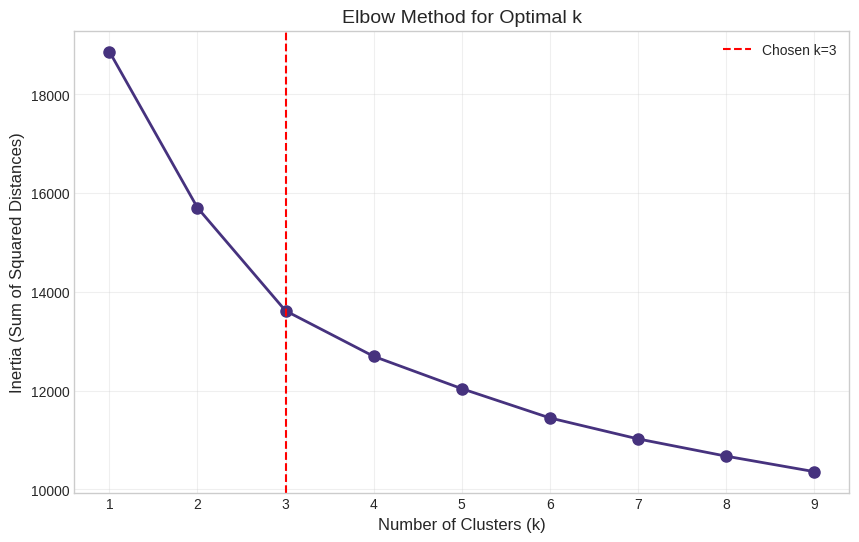

In [ ]:
# Add this code after the data scaling step and before the k-means clustering step

# Elbow Method to find optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate inertia (sum of squared distances to closest centroid) for different k values
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()



For k=2: Silhouette Score = 0.161
For k=3: Silhouette Score = 0.165
For k=4: Silhouette Score = 0.111
For k=5: Silhouette Score = 0.098
For k=6: Silhouette Score = 0.105
For k=7: Silhouette Score = 0.105
For k=8: Silhouette Score = 0.101
For k=9: Silhouette Score = 0.093


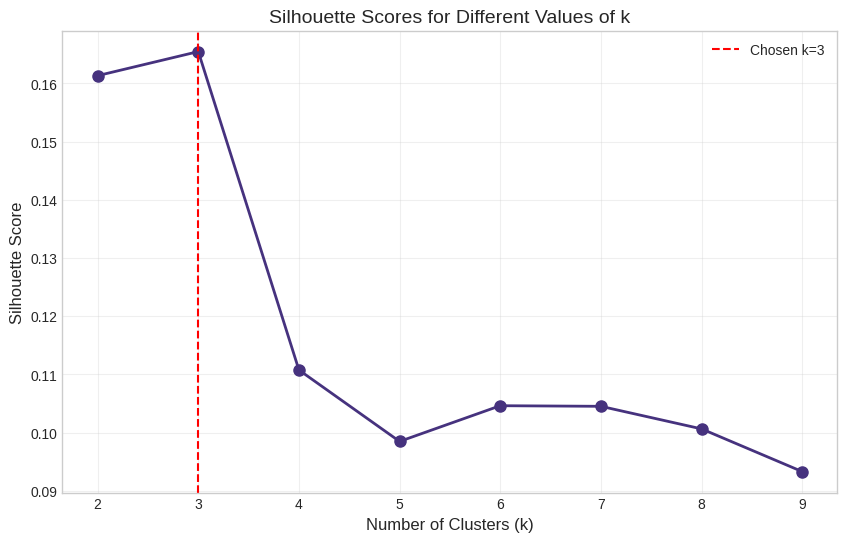

In [ ]:
# Silhouette Scores for different k values
silhouette_scores = []

for k in range(2, 10):  # Silhouette score not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}: Silhouette Score = {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Scores for Different Values of k', fontsize=14)
plt.xticks(range(2, 10))

# Add a vertical line at k=3 to indicate chosen value
plt.axvline(x=3, linestyle='--', color='red', label='Chosen k=3')
plt.legend()
plt.show()



### PCA Visualization for Different Cluster Counts


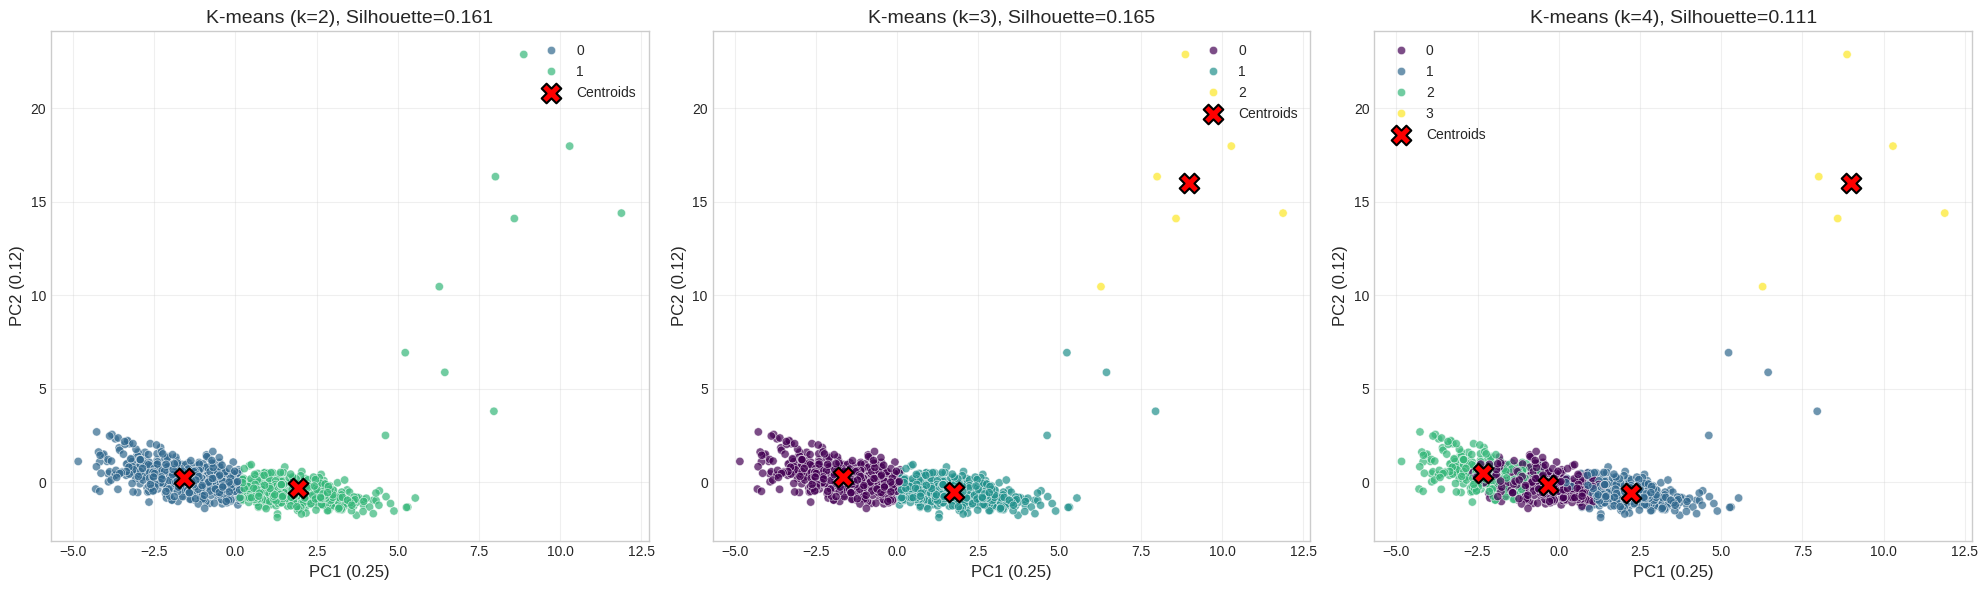

In [ ]:

# Visualize clustering results for k=2, k=3, and k=4 using PCA
print("\n### PCA Visualization for Different Cluster Counts")

# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Create a figure with 3 subplots (one for each k value)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
k_values_to_visualize = [2, 3, 4]

for i, k in enumerate(k_values_to_visualize):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)

    # Add cluster labels to PCA dataframe
    pca_df_k = pca_df.copy()
    pca_df_k['Cluster'] = cluster_labels

    # Plot on the corresponding subplot
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Cluster',
        data=pca_df_k,
        palette='viridis',
        alpha=0.7,
        ax=ax
    )

    # Set subplot title and labels
    ax.set_title(f'K-means (k={k}), Silhouette={silhouette_avg:.3f}', fontsize=14)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Highlight centroid positions
    centroids = kmeans.cluster_centers_
    centroids_pca = pca.transform(centroids)
    ax.scatter(
        centroids_pca[:, 0], centroids_pca[:, 1],
        s=200, marker='X', c='red',
        edgecolor='black', linewidth=1.5,
        label='Centroids'
    )
    ax.legend()

plt.tight_layout()
plt.show()

K-means Clustering with k=3

In [ ]:
# Apply K-means with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_data, customer_features['Cluster'])
print(f"Silhouette Score with {k} clusters: {silhouette_avg:.3f}")

# Create a summary of cluster statistics
cluster_stats = customer_features.groupby('Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    'Avg_Satisfaction': 'mean',
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
cluster_stats.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nCluster Statistics:")
display(cluster_stats.round(2))

Silhouette Score with 3 clusters: 0.165

Cluster Statistics:


,Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Satisfaction,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,8099.64,3.42,2414.06,5.60,5.66,0.66,5.24,524
1,1,19032.53,6.86,2779.74,5.60,5.44,1.37,9.75,463
2,2,409980.97,5.50,81766.13,5.88,6.70,7.55,8.83,6


Visualize Clusters with PCA

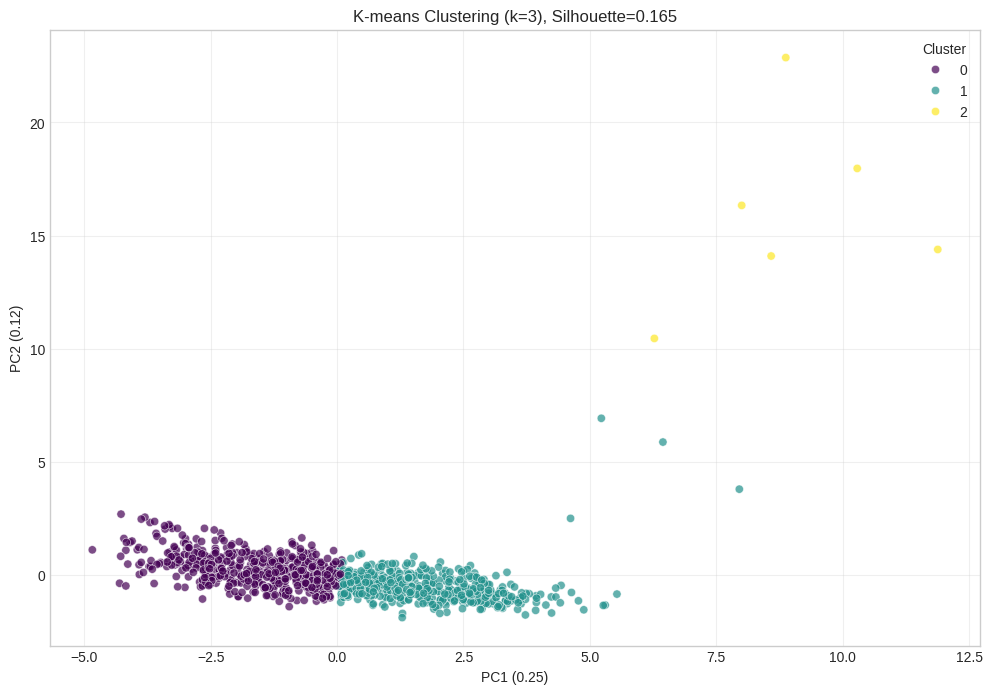

In [ ]:
# PCA visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

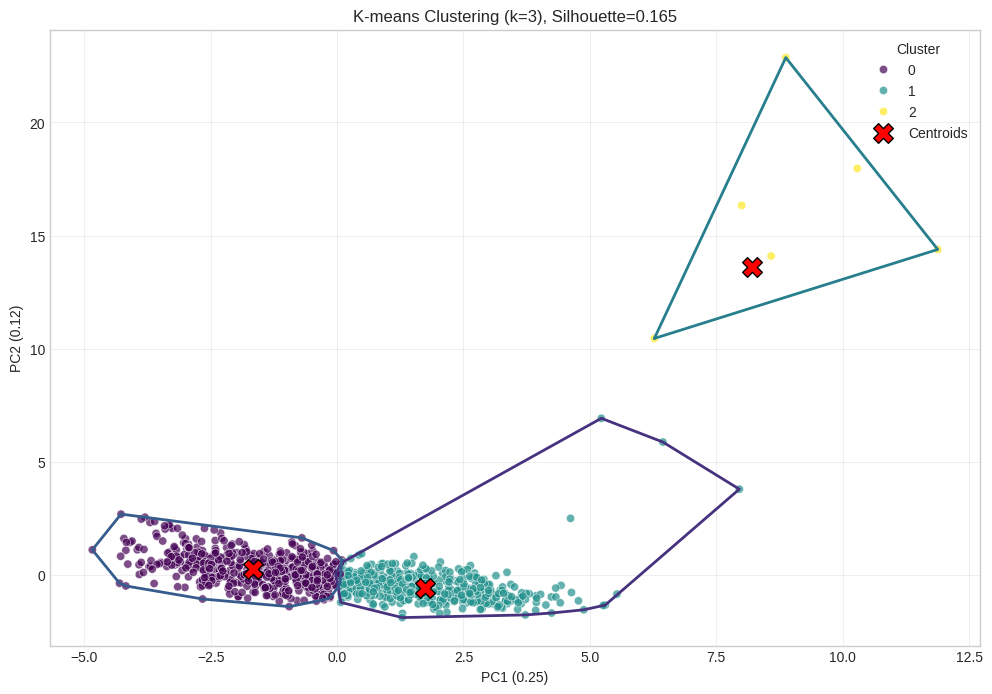

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']

# Perform K-means to get centroids
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(principal_components)  # Using PCA components for centroids
centroids = kmeans.cluster_centers_

# Define a consistent marker style (same shape for all clusters)
marker = 'o'  # Circle for all clusters

# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, marker=marker)

# Draw Convex Hulls for Clusters
for cluster in pca_df['Cluster'].unique():
    cluster_points = pca_df[pca_df['Cluster'] == cluster][['PC1', 'PC2']].values
    if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(cluster_points[hull_vertices, 0], cluster_points[hull_vertices, 1], linestyle='-', linewidth=2)

# Plot the Centroids with consistent shape
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', edgecolors='black', label='Centroids')

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()


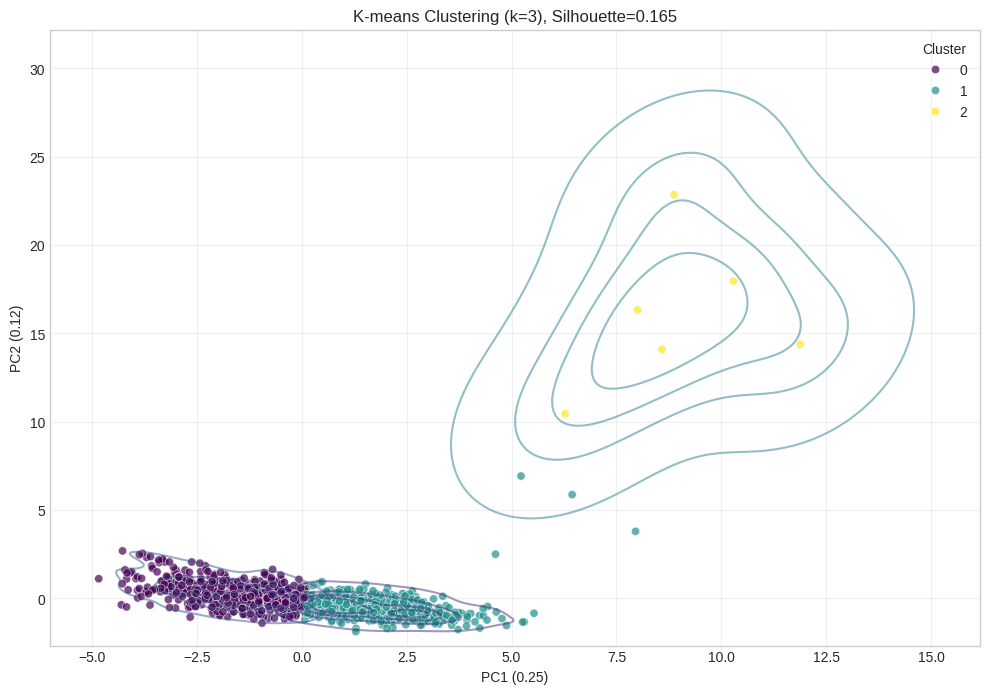

In [ ]:
# Plot Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)

# Draw Density Contour Plots
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    sns.kdeplot(x=cluster_data['PC1'], y=cluster_data['PC2'], levels=5, alpha=0.5)

# Titles and Labels
plt.title(f'K-means Clustering (k={k}), Silhouette={silhouette_avg:.3f}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_features['Cluster']  # Assuming you have cluster labels

# Plot interactive PCA with Plotly
fig = px.scatter(pca_df, x='PC1', y='PC2', color='Cluster',
                 title=f'Interactive PCA Visualization of Clusters (k={k})',
                 labels={'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.2f})',
                         'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.2f})'},
                 hover_data=['Cluster'])

# Show plot
fig.show()


Visualize Clusters with t-SNE

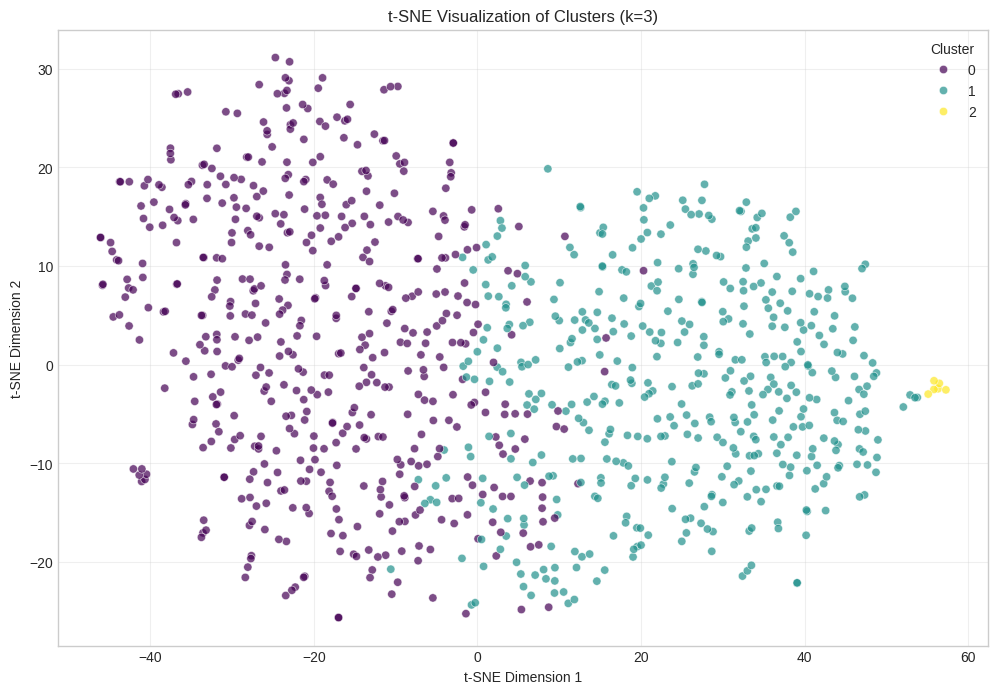

In [ ]:
# t-SNE visualization (this may take a few minutes to run)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='viridis', alpha=0.7)
plt.title(f't-SNE Visualization of Clusters (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()

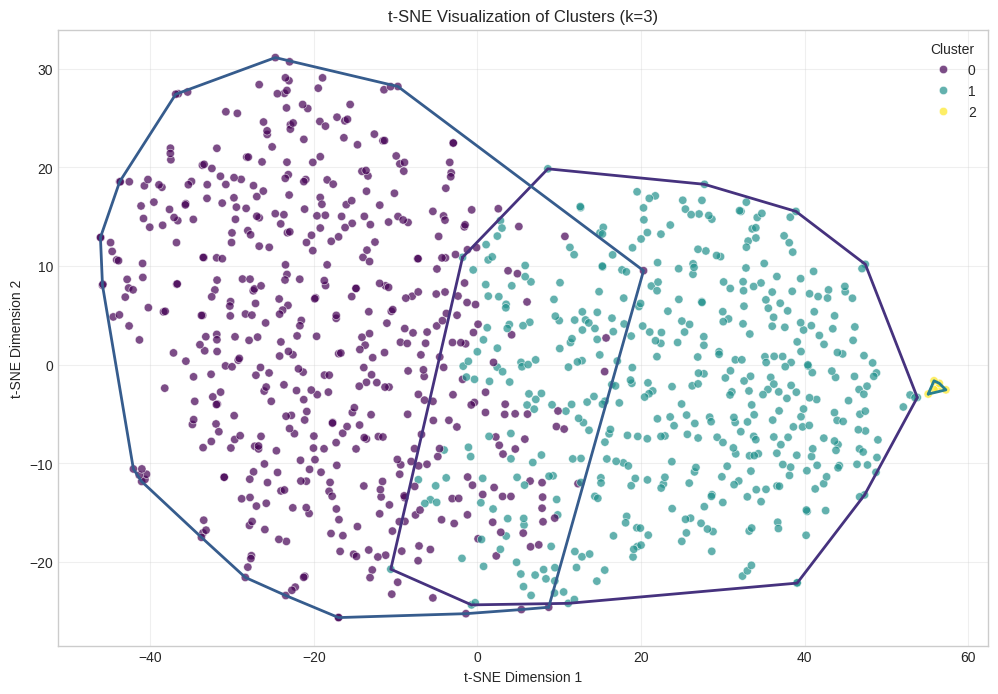

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']


# Define a consistent marker style for all clusters
marker = 'o'  # Circle for all clusters

# Plot Clusters with Same Marker Style for All
plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=tsne_df, palette='viridis', alpha=0.7, marker=marker)

# Draw Convex Hulls for Clusters
for cluster in tsne_df['Cluster'].unique():
    cluster_points = tsne_df[tsne_df['Cluster'] == cluster][['t-SNE1', 't-SNE2']].values
    if len(cluster_points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(cluster_points[hull_vertices, 0], cluster_points[hull_vertices, 1], linestyle='-', linewidth=2)


# Titles and Labels
plt.title(f't-SNE Visualization of Clusters (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()


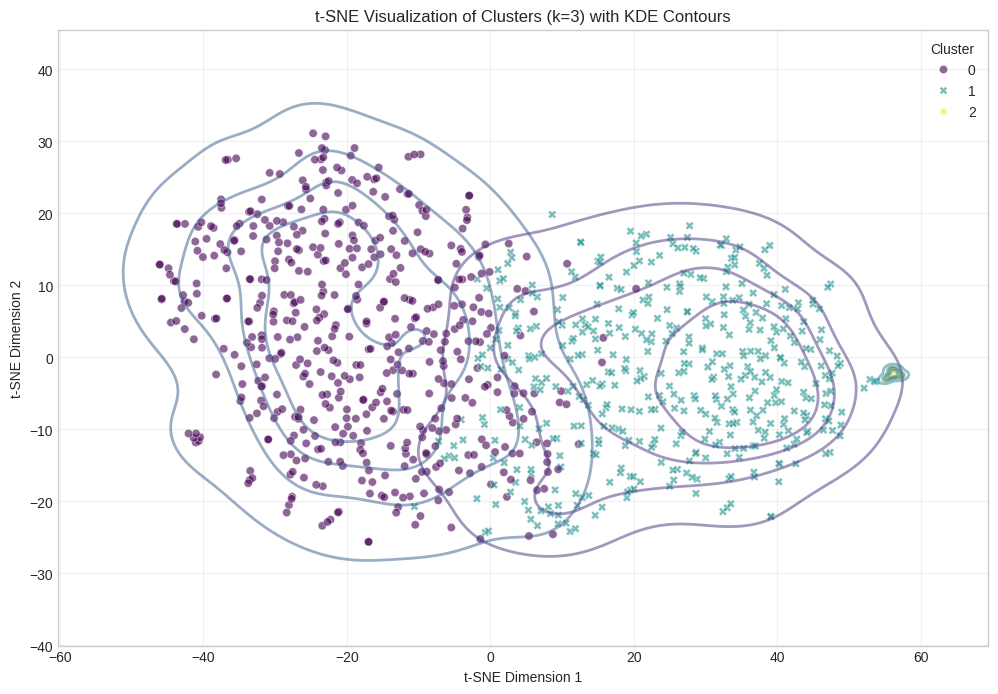

In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']

# Plot Clusters with Contour (KDE) Plots for each Cluster
plt.figure(figsize=(12, 8))

# Create a scatter plot
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', style='Cluster', data=tsne_df, palette='viridis', alpha=0.6)

# Draw Kernel Density Estimation (KDE) contours for each cluster
for cluster in tsne_df['Cluster'].unique():
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    sns.kdeplot(x=cluster_data['t-SNE1'], y=cluster_data['t-SNE2'], levels=5, alpha=0.5, linewidths=2)

# Titles and Labels
plt.title(f't-SNE Visualization of Clusters (k={k}) with KDE Contours')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
tsne_df['Cluster'] = customer_features['Cluster']  # Assuming you have cluster labels

# Plot interactive t-SNE with Plotly
fig = px.scatter(tsne_df, x='t-SNE1', y='t-SNE2', color='Cluster',
                 title=f'Interactive t-SNE Visualization of Clusters (k={k})',
                 labels={'t-SNE1': 't-SNE Dimension 1', 't-SNE2': 't-SNE Dimension 2'},
                 hover_data=['Cluster'])

# Show plot
fig.show()


Visualize Key Metrics by Cluster

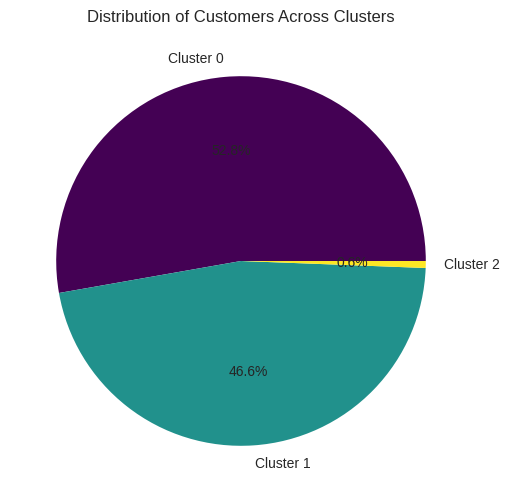

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette for clusters
custom_palette = ['#440154', '#21918c', '#fde725']

# Distribution of customers across clusters
plt.figure(figsize=(10, 6))
cluster_sizes = customer_features['Cluster'].value_counts().sort_index()

# Plot pie chart with custom color palette
plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', colors=custom_palette)
plt.title('Distribution of Customers Across Clusters')
plt.show()


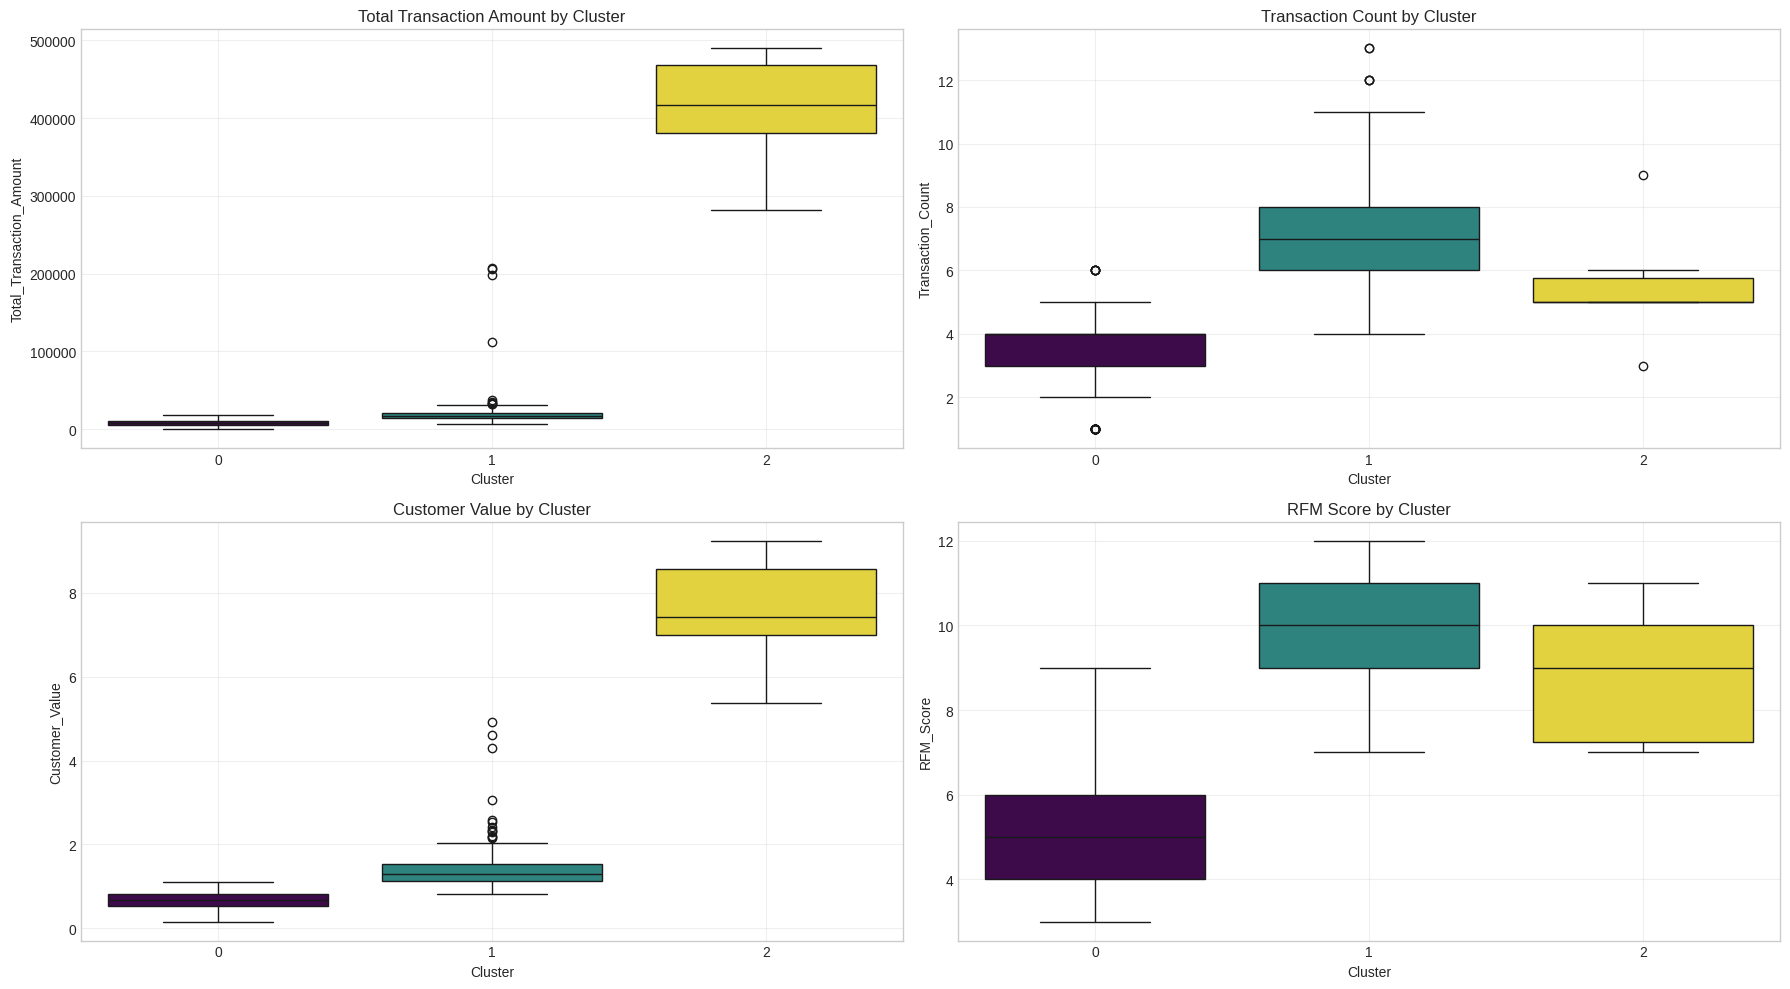

In [ ]:
# Define custom color palette for clusters
custom_palette = {'0': '#440154', '1': '#21918c', '2': '#fde725'}

# Visualize key metrics by cluster
plt.figure(figsize=(18, 10))

# Transaction Amount
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Total_Transaction_Amount', data=customer_features, palette=custom_palette)
plt.title('Total Transaction Amount by Cluster')
plt.grid(True, alpha=0.3)

# Transaction Count
plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='Transaction_Count', data=customer_features, palette=custom_palette)
plt.title('Transaction Count by Cluster')
plt.grid(True, alpha=0.3)

# Customer Value
plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Customer_Value', data=customer_features, palette=custom_palette)
plt.title('Customer Value by Cluster')
plt.grid(True, alpha=0.3)

# RFM Score
plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='RFM_Score', data=customer_features, palette=custom_palette)
plt.title('RFM Score by Cluster')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Validate with Hierarchical Clustering

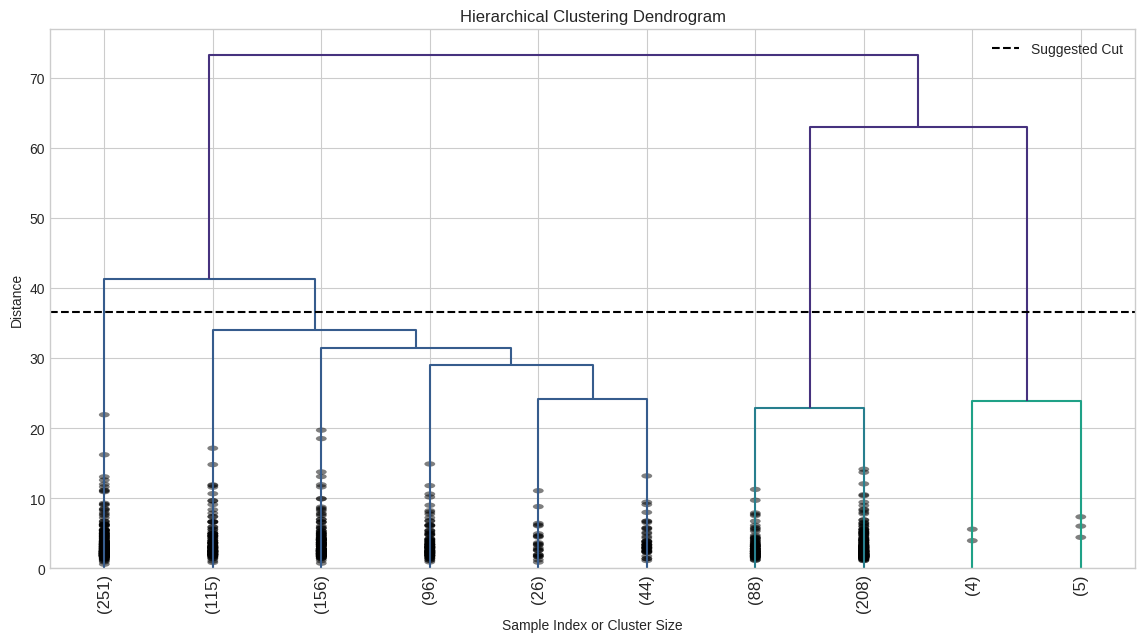

Hierarchical Clustering Silhouette Score: 0.126

Hierarchical Clustering Statistics:


,Hierarchical_Cluster,Total_Transaction_Amount,Transaction_Count,Avg_Transaction_Amount,Avg_Satisfaction,Avg_Recommendation,Customer_Value,RFM_Score,Customer_Count
0,0,9812.92,3.93,2501.98,5.52,5.64,0.77,6.12,688
1,1,19235.05,7.56,2541.61,5.77,5.38,1.48,10.19,296
2,2,341254.58,6.44,63211.44,5.87,6.12,6.57,9.56,9


In [ ]:
# Hierarchical clustering
Z = linkage(scaled_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=10,  # Show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=np.max(Z[:, 2])/2, c='k', linestyle='--', label='Suggested Cut')
plt.legend()
plt.show()

# Cut the dendrogram to get hierarchical clusters (using 3 clusters like K-means)
hierarchical_labels = fcluster(Z, t=3, criterion='maxclust')
hierarchical_labels = hierarchical_labels - 1  # Adjust to start from 0 for consistency with K-means

# Calculate silhouette score for hierarchical clustering
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.3f}")

# Add hierarchical labels to the data
customer_features['Hierarchical_Cluster'] = hierarchical_labels

# Create a summary of hierarchical cluster characteristics
hierarchical_summary = customer_features.groupby('Hierarchical_Cluster').agg({
    'Total_Transaction_Amount': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Transaction_Amount': 'mean',
    'Avg_Satisfaction': 'mean',
    'Avg_Recommendation': 'mean',
    'Customer_Value': 'mean',
    'RFM_Score': 'mean',
    'Customer_ID': 'count'
}).reset_index()
hierarchical_summary.rename(columns={'Customer_ID': 'Customer_Count'}, inplace=True)

print("\nHierarchical Clustering Statistics:")
display(hierarchical_summary.round(2))

Validate with DBSCAN

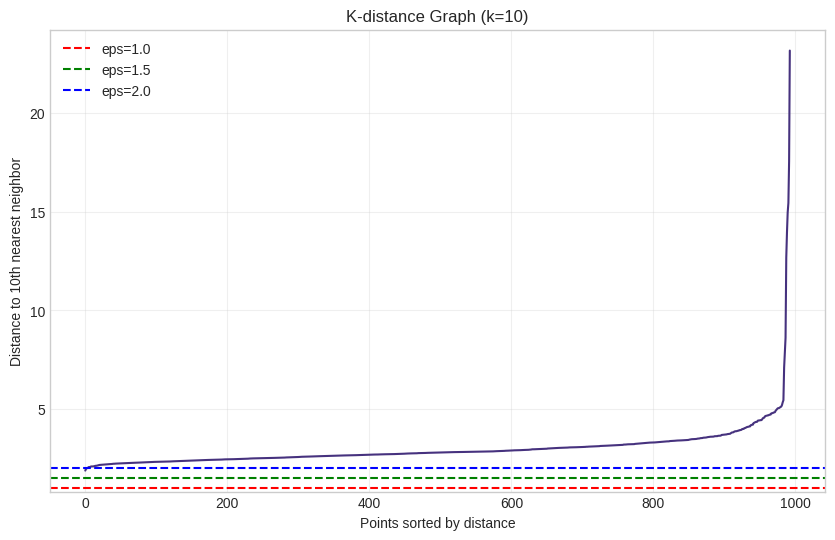

DBSCAN found 0 clusters and 993 noise points


In [ ]:
# Find optimal epsilon using k-distance graph
k = min(10, len(scaled_data)-1)  # Use 10 or one less than dataset size if smaller
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for the k-th neighbor
distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=1.0, c='r', linestyle='--', label='eps=1.0')
plt.axhline(y=1.5, c='g', linestyle='--', label='eps=1.5')
plt.axhline(y=2.0, c='b', linestyle='--', label='eps=2.0')
plt.title(f'K-distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Apply DBSCAN with reasonable parameters
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# Add DBSCAN labels to the data
customer_features['DBSCAN_Cluster'] = dbscan_labels

# If DBSCAN found clusters, create statistics for non-noise clusters
if n_clusters > 0:
    non_noise_mask = customer_features['DBSCAN_Cluster'] != -1
    dbscan_summary = customer_features[non_noise_mask].groupby('DBSCAN_Cluster').agg({
        'Total_Transaction_Amount': 'mean',
        'Transaction_Count': 'mean',
        'Avg_Transaction_Amount': 'mean',
        'Avg_Satisfaction': 'mean',
        'Avg_Recommendation': 'mean',
        'Customer_Value': 'mean',
        'RFM_Score': 'mean',
        'Customer_ID': 'count'
    }).reset_index()
    dbscan_summary.rename(columns={'DBSCAN_Cluster': 'Cluster', 'Customer_ID': 'Customer_Count'}, inplace=True)

    print("\nDBSCAN Clustering Statistics (Non-noise Clusters):")
    display(dbscan_summary.round(2))

Statistical Validation of Cluster Differentiation

Setup and Define Key Metrics

In [ ]:
# Define the key metrics to test
key_metrics = [
    'Total_Transaction_Amount',
    'Transaction_Count',
    'Avg_Transaction_Amount',
    'Avg_Satisfaction',
    'Avg_Recommendation',
    'Customer_Value',
    'RFM_Score',
    'Engagement_Score'
]

ANOVA Tests

In [ ]:
# 1. Perform ANOVA test for each metric
print("\n### ANOVA Tests")
print("Testing if significant differences exist between clusters for key metrics:")
anova_results = {}
for metric in key_metrics:
    # Extract data for each cluster
    groups = [customer_features[customer_features['Cluster'] == cluster][metric].values
             for cluster in sorted(customer_features['Cluster'].unique())]
    # Perform ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    # Store results
    anova_results[metric] = {
        'F_Statistic': f_stat,
        'P_Value': p_val,
        'Significant': p_val < 0.05
    }

# Display ANOVA results as a table
anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.reset_index().rename(columns={'index': 'Metric'})
anova_df = anova_df.sort_values('P_Value')
display(anova_df)


### ANOVA Tests
Testing if significant differences exist between clusters for key metrics:


,Metric,F_Statistic,P_Value,Significant
0,Total_Transaction_Amount,3001.070381,0.0,True
2,Avg_Transaction_Amount,2358.560562,0.0,True
5,Customer_Value,1684.659309,0.0,True
6,RFM_Score,1093.628194,0.0,True
1,Transaction_Count,779.686942,0.0,True
7,Engagement_Score,581.461872,0.0,True
4,Avg_Recommendation,4.674891,0.009533,True
3,Avg_Satisfaction,0.124423,0.88302,False


Visualize ANOVA Results

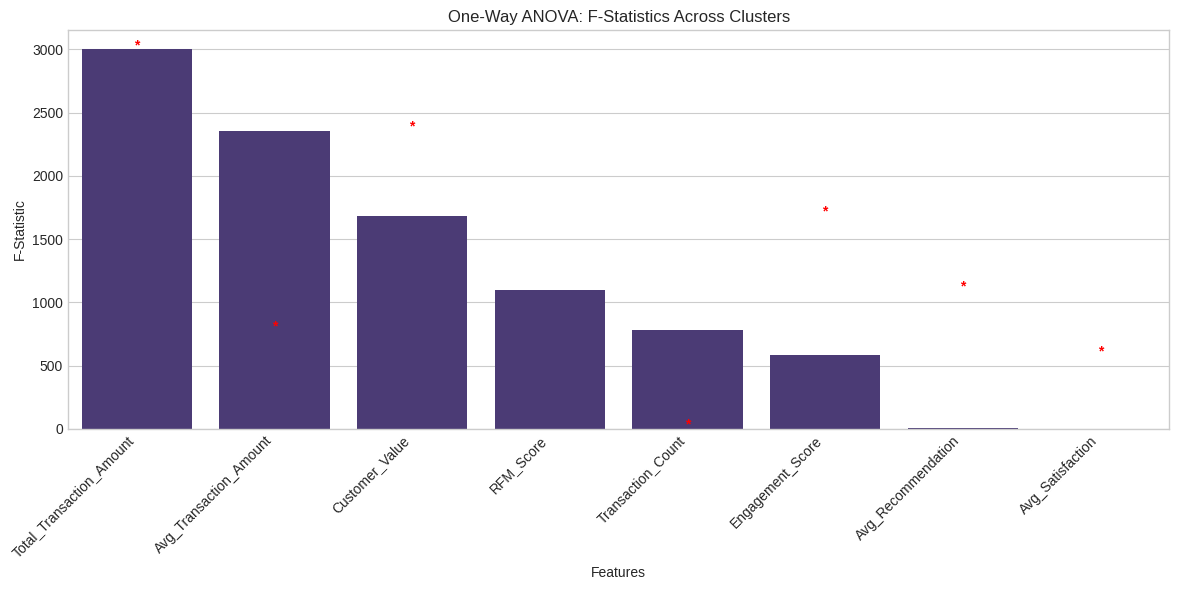

In [ ]:
# Visualize ANOVA results
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='F_Statistic', data=anova_df)
for i, row in anova_df.iterrows():
    if row['Significant']:
        plt.text(i, row['F_Statistic'], '*', horizontalalignment='center', color='red', fontweight='bold')
plt.title('One-Way ANOVA: F-Statistics Across Clusters')
plt.xlabel('Features')
plt.ylabel('F-Statistic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tukey's HSD Post-hoc Tests

In [ ]:
# 2. Post-hoc pairwise tests (Tukey's HSD)
print("\n### Pairwise Cluster Comparisons")
print("Testing which specific clusters differ from each other:")

clusters = sorted(customer_features['Cluster'].unique())
cluster_pairs = [(c1, c2) for i, c1 in enumerate(clusters) for c2 in clusters[i+1:]]

tukey_results = {}
for metric in key_metrics:
    if anova_results[metric]['Significant']:
        # Prepare data for Tukey test
        tukey_input = customer_features[metric]
        cluster_labels = customer_features['Cluster']

        # Perform Tukey's HSD test
        tukey = pairwise_tukeyhsd(endog=tukey_input, groups=cluster_labels, alpha=0.05)

        # Convert to DataFrame for easier interpretation
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],
                              columns=tukey._results_table.data[0])
        tukey_results[metric] = tukey_df

        print(f"\nTukey HSD Test Results for {metric}:")
        display(tukey_df)


### Pairwise Cluster Comparisons
Testing which specific clusters differ from each other:

Tukey HSD Test Results for Total_Transaction_Amount:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,10932.8921,0.0,9031.4732,12834.3110,True
1,0,2,401881.3363,0.0,389641.6007,414121.0718,True
2,1,2,390948.4442,0.0,378699.5842,403197.3041,True



Tukey HSD Test Results for Transaction_Count:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,3.4335,0.0000,3.2294,3.6377,True
1,0,2,2.0782,0.0006,0.7642,3.3923,True
2,1,2,-1.3553,0.0416,-2.6703,-0.0403,True



Tukey HSD Test Results for Avg_Transaction_Amount:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,365.6868,0.1043,-55.9997,787.3733,False
1,0,2,79352.0705,0.0000,76637.6073,82066.5336,True
2,1,2,78986.3837,0.0000,76269.8969,81702.8704,True



Tukey HSD Test Results for Avg_Recommendation:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,-0.2213,0.0457,-0.4394,-0.0033,True
1,0,2,1.0391,0.1917,-0.3645,2.4427,False
2,1,2,1.2605,0.0891,-0.1442,2.6651,False



Tukey HSD Test Results for Customer_Value:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,0.7069,0.0,0.6567,0.7571,True
1,0,2,6.8875,0.0,6.5643,7.2108,True
2,1,2,6.1806,0.0,5.8571,6.5042,True



Tukey HSD Test Results for RFM_Score:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,4.5085,0.0000,4.2819,4.7351,True
1,0,2,3.5967,0.0000,2.1382,5.0552,True
2,1,2,-0.9118,0.3076,-2.3714,0.5478,False



Tukey HSD Test Results for Engagement_Score:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0,1,1.8815,0.0000,1.7520,2.0110,True
1,0,2,1.0664,0.0077,0.2326,1.9001,True
2,1,2,-0.8152,0.0572,-1.6495,0.0192,False


Create Differentiation Heatmap

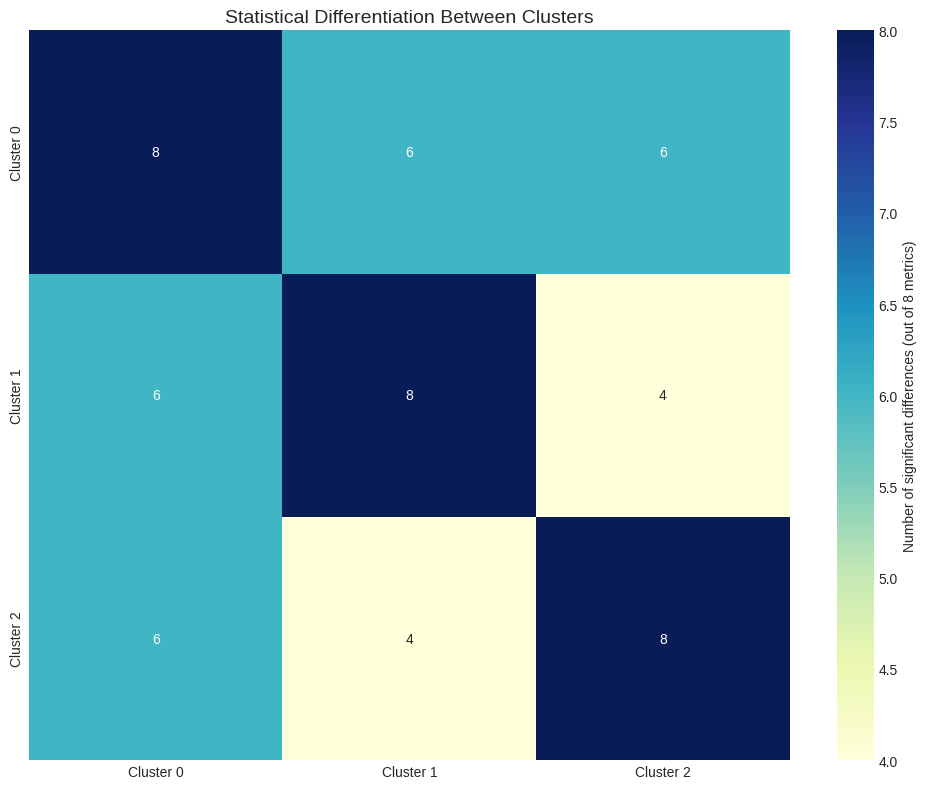

In [ ]:
# 3. Create a heatmap showing the differentiation between clusters
# Count how many metrics show significant differences for each cluster pair
significant_diff_count = {}
for tukey_df in tukey_results.values():
    for _, row in tukey_df.iterrows():
        pair_key = f"{row['group1']}-{row['group2']}"
        if pair_key not in significant_diff_count:
            significant_diff_count[pair_key] = 0
        if row['reject']:
            significant_diff_count[pair_key] += 1

# Prepare data for heatmap
heatmap_data = np.zeros((len(clusters), len(clusters)))
for i, c1 in enumerate(clusters):
    for j, c2 in enumerate(clusters):
        if i == j:
            # Diagonal elements (same cluster) set to max differentiation
            heatmap_data[i, j] = len(key_metrics)
        elif f"{c1}-{c2}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c1}-{c2}"]
        elif f"{c2}-{c1}" in significant_diff_count:
            heatmap_data[i, j] = significant_diff_count[f"{c2}-{c1}"]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu',
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=[f'Cluster {c}' for c in clusters],
    cbar_kws={'label': 'Number of significant differences (out of ' + str(len(key_metrics)) + ' metrics)'}
)
plt.title('Statistical Differentiation Between Clusters', fontsize=14)
plt.tight_layout()
plt.show()

Silhouette Score Analysis

In [ ]:
# 4. Silhouette analysis for individual clusters
print("\n### Silhouette Score Analysis")
print("Measuring how well each data point fits within its assigned cluster:")

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(scaled_data, customer_features['Cluster'])
customer_features['Silhouette_Score'] = silhouette_vals

# Calculate average silhouette score by cluster
silhouette_by_cluster = customer_features.groupby('Cluster')['Silhouette_Score'].mean().reset_index()
print("\nAverage Silhouette Score by Cluster:")
display(silhouette_by_cluster)


### Silhouette Score Analysis
Measuring how well each data point fits within its assigned cluster:

Average Silhouette Score by Cluster:


,Cluster,Silhouette_Score
0,0,0.076513
1,1,0.261365
2,2,0.535089


Visualize Silhouette Scores

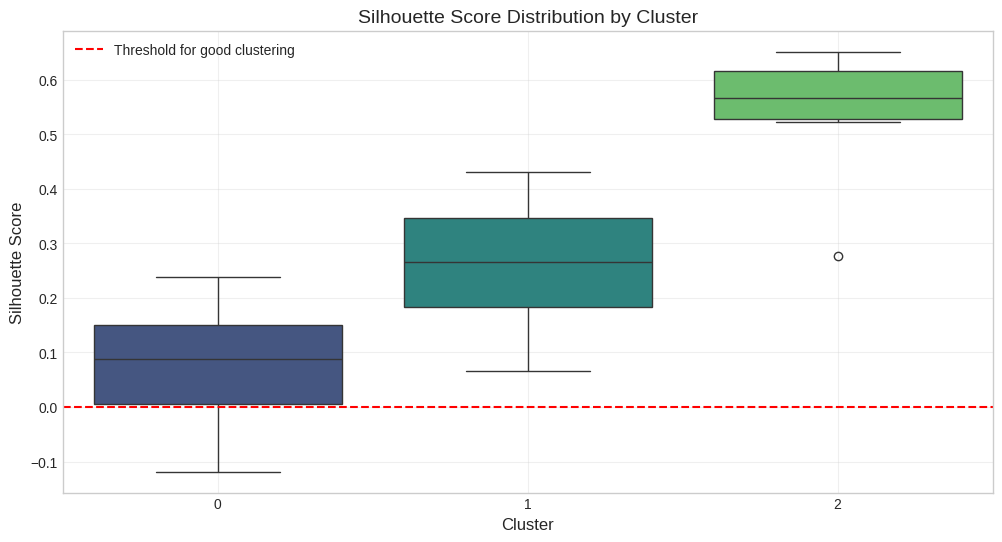

In [ ]:
# Visualize silhouette scores
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Silhouette_Score', data=customer_features, palette='viridis')
plt.axhline(y=0, color='red', linestyle='--', label='Threshold for good clustering')
plt.title('Silhouette Score Distribution by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
print("\n### Statistical Validation Summary")
print(f"Total metrics tested: {len(key_metrics)}")
print(f"Metrics with significant ANOVA: {sum(anova_df['Significant'])} out of {len(key_metrics)}")

# Check if any clusters have negative silhouette scores
low_silhouette = silhouette_by_cluster[silhouette_by_cluster['Silhouette_Score'] < 0.1]
if len(low_silhouette) > 0:
    print(f"\nWarning: Clusters {', '.join(low_silhouette['Cluster'].astype(str))} have low silhouette scores (<0.1)")
    print("Consider revisiting the features used for clustering.")
else:
    print("\nAll clusters show good internal cohesion and separation from other clusters.")


### Statistical Validation Summary
Total metrics tested: 8
Metrics with significant ANOVA: 7 out of 8

Consider revisiting the features used for clustering.



### ANOVA Tests
Testing if significant differences exist between clusters for key metrics:
                     Metric  F_Statistic   P_Value Significant
0  Total_Transaction_Amount  3012.817095       0.0        True
2    Avg_Transaction_Amount  2355.883556       0.0        True
4            Customer_Value  1769.305434       0.0        True
5                 RFM_Score   899.912554       0.0        True
1         Transaction_Count   863.632228       0.0        True
6          Engagement_Score   616.563869       0.0        True
3        Avg_Recommendation     4.766856  0.008703        True


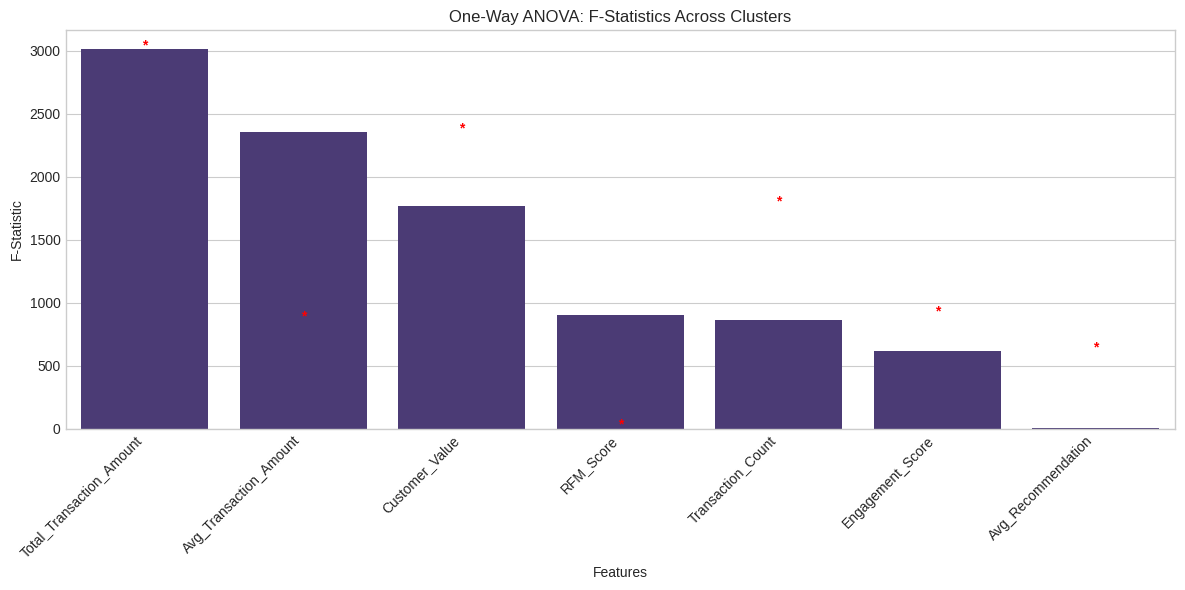


### Pairwise Cluster Comparisons

Tukey HSD Test Results for Total_Transaction_Amount:
   group1  group2     meandiff  p-adj        lower        upper  reject
0       0       1  -11292.3313    0.0  -13235.3693   -9349.2933    True
1       0       2  389853.7731    0.0  377609.3580  402098.1883    True
2       1       2  401146.1044    0.0  388935.9447  413356.2642    True

Tukey HSD Test Results for Transaction_Count:
   group1  group2  meandiff   p-adj   lower   upper  reject
0       0       1   -3.5829  0.0000 -3.7853 -3.3805    True
1       0       2   -1.7214  0.0045 -2.9968 -0.4459    True
2       1       2    1.8615  0.0018  0.5897  3.1334    True

Tukey HSD Test Results for Avg_Transaction_Amount:
   group1  group2    meandiff   p-adj       lower       upper  reject
0       0       1   -329.6631  0.1728   -761.5056    102.1795   False
1       0       2  78979.1223  0.0000  76257.7863  81700.4583    True
2       1       2  79308.7854  0.0000  76595.0627  82022.5081    True

Tuke

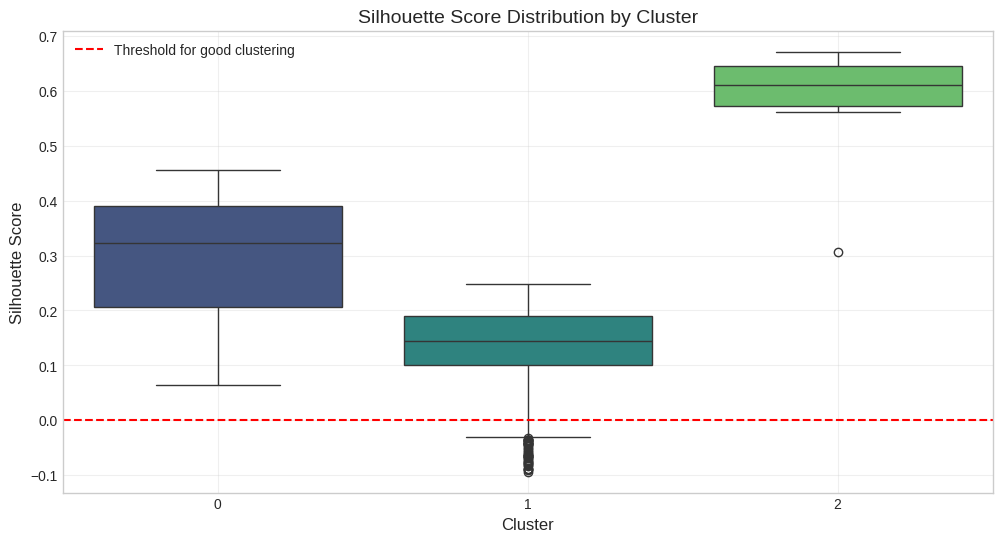

In [ ]:
# Testing when Avg_Satisfaction	is removed from features
def run_clustering_without_avg_satisfaction(customer_data):
    # Step 1: Remove the 'Avg_Satisfaction' feature from the dataset
    customer_data_cleaned = customer_data.drop(columns=['Avg_Satisfaction'])

    # Step 2: Feature Engineering - Standardize the data (except the 'Cluster' column)
    feature_data = customer_data_cleaned.drop(columns=['Cluster'])  # Assuming 'Cluster' is already assigned
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_data)

    # Step 3: K-means Clustering (using 3 clusters as in the previous example)
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(scaled_features)
    customer_data_cleaned['Cluster'] = kmeans.labels_

    # Step 4: Add Silhouette Scores to DataFrame
    silhouette_vals = silhouette_samples(scaled_features, customer_data_cleaned['Cluster'])
    customer_data_cleaned['Silhouette_Score'] = silhouette_vals

    # Step 5: Statistical Tests - ANOVA (F-test) across clusters for each feature
    key_metrics = [
        'Total_Transaction_Amount', 'Transaction_Count', 'Avg_Transaction_Amount',
        'Avg_Recommendation', 'Customer_Value', 'RFM_Score', 'Engagement_Score'
    ]

    # Perform ANOVA
    print("\n### ANOVA Tests")
    print("Testing if significant differences exist between clusters for key metrics:")
    anova_results = {}
    for metric in key_metrics:
        # Extract data for each cluster
        groups = [customer_data_cleaned[customer_data_cleaned['Cluster'] == cluster][metric].values
                 for cluster in sorted(customer_data_cleaned['Cluster'].unique())]
        # Perform ANOVA
        f_stat, p_val = f_oneway(*groups)
        # Store results
        anova_results[metric] = {'F_Statistic': f_stat, 'P_Value': p_val, 'Significant': p_val < 0.05}

    # Display ANOVA results as a table
    anova_df = pd.DataFrame(anova_results).T
    anova_df = anova_df.reset_index().rename(columns={'index': 'Metric'})
    anova_df = anova_df.sort_values('P_Value')
    print(anova_df)

    # Visualize ANOVA results
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='F_Statistic', data=anova_df)
    for i, row in anova_df.iterrows():
        if row['Significant']:
            plt.text(i, row['F_Statistic'], '*', horizontalalignment='center', color='red', fontweight='bold')
    plt.title('One-Way ANOVA: F-Statistics Across Clusters')
    plt.xlabel('Features')
    plt.ylabel('F-Statistic')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Step 6: Post-hoc pairwise tests (Tukey's HSD) for significant features
    print("\n### Pairwise Cluster Comparisons")
    tukey_results = {}
    for metric in key_metrics:
        if anova_results[metric]['Significant']:
            tukey_input = customer_data_cleaned[metric]
            cluster_labels = customer_data_cleaned['Cluster']

            tukey = pairwise_tukeyhsd(endog=tukey_input, groups=cluster_labels, alpha=0.05)
            tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],
                                  columns=tukey._results_table.data[0])
            tukey_results[metric] = tukey_df
            print(f"\nTukey HSD Test Results for {metric}:")
            print(tukey_df)

    # Step 7: Silhouette Analysis
    print("\n### Silhouette Score Analysis")
    silhouette_by_cluster = customer_data_cleaned.groupby('Cluster')['Silhouette_Score'].mean().reset_index()
    print(silhouette_by_cluster)

    # Visualize silhouette scores
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Cluster', y='Silhouette_Score', data=customer_data_cleaned, palette='viridis')
    plt.axhline(y=0, color='red', linestyle='--', label='Threshold for good clustering')
    plt.title('Silhouette Score Distribution by Cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return customer_data_cleaned, anova_df, tukey_results, silhouette_by_cluster

# Example usage:
# Assuming you have a DataFrame `customer_features` with columns like 'Cluster', 'Total_Transaction_Amount', etc.
customer_data, anova_df, tukey_results, silhouette_by_cluster = run_clustering_without_avg_satisfaction(customer_features)
